In [1]:
### Magic functinos
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [2]:
### imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import mean_ci
from mliv.neuralnet import AGMMEarlyStop as AGMM
from mliv.neuralnet.moments import avg_small_diff
from sklearn.ensemble import RandomForestRegressor

## $\ell_2$-Regularized AGMM with Neural Net Test Function

We solve the problem:
\begin{equation}
\min_{\theta} \max_{w} \frac{1}{n} \sum_i (y_i - h_{\theta}(x_i)) f_w(z_i) - f_w(z_i)^2
\end{equation}
where $h_{\theta}$ and $f_w$ are two neural nets.

In [4]:
def exp(it, n, n_z, n_t, iv_strength, fname, dgp_num, moment_fn, special_test=True, lambda_l2_h=0):
    np.random.seed(it)
    
    #####
    # Neural network parameters
    ####
    p = 0.1 # dropout prob of dropout layers throughout notebook
    n_hidden = 100 # width of hidden layers throughout notebook
    learner_lr = 1e-4
    adversary_lr = 1e-4
    learner_l2 = 1e-3
    adversary_l2 = 1e-3
    n_epochs = 200
    bs = 100
    burn_in = 100
    device = None
    
    ######
    # Train test split
    ######
    Z, T, Y, true_fn = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
    Z_train, Z_val, T_train, T_val, Y_train, Y_val = train_test_split(Z, T, Y, test_size=.5, shuffle=True)
    Z_train, T_train, Y_train = map(lambda x: torch.Tensor(x), (Z_train, T_train, Y_train))
    Z_val, T_val, Y_val = map(lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val))

    
    #####
    # Train "riesz" representer xi
    #####
    np.random.seed(12356)
    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                                 nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    reisz = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, Z_val, T_val, Y_val,
                                            learner_lr=learner_lr, adversary_lr=adversary_lr,
                                            learner_l2=learner_l2, adversary_l2=adversary_l2,
                                            n_epochs=n_epochs, bs=bs, logger=None,
                                            model_dir=f'riesz_model_{it}', device=device,
                                            riesz=True, moment_fn=moment_fn)
    
    ######
    # Train "riesz" representer q
    ######
    qfun = RandomForestRegressor(min_samples_leaf=20).fit(Z_train, reisz.predict(T_train).ravel())
    qfun_avg = RandomForestRegressor(min_samples_leaf=20).fit(Z_train,
                                                              reisz.predict(T_train,
                                                                            model='avg', burn_in=burn_in).ravel())
    
    ######
    # Train IV function h
    ######

    # Add "clever instrument" to instrument vector
    augZ_val = Z_val
    augZ_train = Z_train
    if special_test:
        qtrain = torch.tensor(qfun.predict(Z_train).reshape(-1, 1)).float()
        augZ_train = torch.cat([qtrain, Z_train], dim=1)
        qval = torch.tensor(qfun.predict(Z_val).reshape(-1, 1)).float()
        augZ_val = torch.cat([qval, Z_val], dim=1)

    adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(augZ_train.shape[1], n_hidden), nn.LeakyReLU(),
                                 nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    
    agmm = AGMM(learner, adversary_fn, special_test=special_test)
    agmm.fit(augZ_train, T_train, Y_train, augZ_val, T_val, Y_val,
             learner_lr=learner_lr, adversary_lr=adversary_lr,
             learner_l2=learner_l2, adversary_l2=adversary_l2,
             learner_tikhonov=lambda_l2_h,
             n_epochs=n_epochs, bs=bs, logger=None,
             model_dir=f'agmm_model_{it}', device=device)

    
    #####
    # Average moment calculation
    #####
    direct = moment_fn(T_val, agmm.predict, device='cpu').flatten()
    residual = (Y_val - agmm.predict(T_val)).detach().numpy().flatten()
    qvalues = qfun.predict(Z_val).flatten()
    pseudo = direct + qvalues * residual
    dr = mean_ci(pseudo)
    ipw = mean_ci(qvalues * Y_val.detach().numpy().flatten())
    reg = mean_ci(direct)
    
    xivalues = reisz.predict(T_val).flatten()
    coef = np.mean(qvalues * residual) / np.mean(qvalues * xivalues)
    pseudo_tmle = direct + coef * moment_fn(T_val, reisz.predict, device='cpu').flatten()
    pseudo_tmle += qvalues * (residual - coef * xivalues)
    tmle = mean_ci(pseudo_tmle)

    direct_avg = moment_fn(T_val,
                           lambda x: agmm.predict(x, model='avg', burn_in=burn_in), device='cpu').flatten()
    residual_avg = (Y_val - agmm.predict(T_val, model='avg', burn_in=burn_in)).detach().numpy().flatten()
    qvalues_avg = qfun_avg.predict(Z_val).flatten()
    pseudo_avg = direct_avg + qvalues_avg * residual_avg
    dr_avg = mean_ci(pseudo_avg)
    ipw_avg = mean_ci(qvalues_avg * Y_val.detach().numpy().flatten())
    reg_avg = mean_ci(direct_avg)

    xivalues_avg = reisz.predict(T_val, model='avg', burn_in=burn_in).flatten()
    coef_avg = np.mean(qvalues_avg * residual_avg) / np.mean(qvalues_avg * xivalues_avg)
    pseudo_tmle_avg = (direct_avg 
                       + coef_avg * moment_fn(T_val, lambda x: reisz.predict(x, model='avg', burn_in=burn_in),
                                              device='cpu').flatten())
    pseudo_tmle_avg += qvalues_avg * (residual_avg - coef_avg * xivalues_avg)
    tmle_avg = mean_ci(pseudo_tmle_avg)

    return dr, tmle, ipw, reg, dr_avg, tmle_avg, ipw_avg, reg_avg

In [5]:
n = 500
n_z = 1
n_t = 1
iv_strength = .7
fname = 'sigmoid'
dgp_num = 5
epsilon = 0.1 # average finite difference epsilon
moment_fn = lambda x, fn, device: avg_small_diff(x, fn, device, epsilon)
lambda_l2_h = 1/n**(.9)
clever = True

Z, T, Y, true_fn = get_data(1000000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
true = np.mean(moment_fn(T, true_fn, device='cpu'))
print(f'True: {true:.4f}')

True: 0.1906


In [6]:
exp(1, n, n_z, n_t, iv_strength, fname, dgp_num, moment_fn, clever, lambda_l2_h)

f(z_dev) collection prepared.
Epoch #0
Current moment approx: 0.08652808517217636
Epoch #1
Current moment approx: 0.08540357649326324
Epoch #2
Current moment approx: 0.08264731615781784
Epoch #3
Current moment approx: 0.08085412532091141
Epoch #4
Current moment approx: 0.07773159444332123
Epoch #5
Current moment approx: 0.07463802397251129
Epoch #6
Current moment approx: 0.07152723520994186
Epoch #7
Current moment approx: 0.06886003166437149
Epoch #8
Current moment approx: 0.06699676811695099
Epoch #9
Current moment approx: 0.06472945958375931
Epoch #10
Current moment approx: 0.06176187843084335
Epoch #11
Current moment approx: 0.058573976159095764
Epoch #12
Current moment approx: 0.05649552866816521
Epoch #13
Current moment approx: 0.05325132608413696
Epoch #14
Current moment approx: 0.05072099715471268
Epoch #15
Current moment approx: 0.04740443825721741
Epoch #16
Current moment approx: 0.044776856899261475
Epoch #17
Current moment approx: 0.042348846793174744
Epoch #18
Current momen

Current moment approx: -0.19016431272029877
Epoch #158
Current moment approx: -0.19200584292411804
Epoch #159
Current moment approx: -0.19314222037792206
Epoch #160
Current moment approx: -0.19438853859901428
Epoch #161
Current moment approx: -0.19547441601753235
Epoch #162
Current moment approx: -0.19721797108650208
Epoch #163
Current moment approx: -0.1985693871974945
Epoch #164
Current moment approx: -0.20012183487415314
Epoch #165
Current moment approx: -0.2011066973209381
Epoch #166
Current moment approx: -0.20199115574359894
Epoch #167
Current moment approx: -0.2021285891532898
Epoch #168
Current moment approx: -0.2040739506483078
Epoch #169
Current moment approx: -0.20577865839004517
Epoch #170
Current moment approx: -0.20626525580883026
Epoch #171
Current moment approx: -0.20841403305530548
Epoch #172
Current moment approx: -0.2100256383419037
Epoch #173
Current moment approx: -0.21042512357234955
Epoch #174
Current moment approx: -0.21122193336486816
Epoch #175
Current moment 

Current moment approx: 0.009410623461008072
Epoch #119
Current moment approx: 0.012530718930065632
Epoch #120
Current moment approx: 0.01448560319840908
Epoch #121
Current moment approx: 0.017327357083559036
Epoch #122
Current moment approx: 0.021041588857769966
Epoch #123
Current moment approx: 0.02425841987133026
Epoch #124
Current moment approx: 0.02746565453708172
Epoch #125
Current moment approx: 0.030617916956543922
Epoch #126
Current moment approx: 0.03363699093461037
Epoch #127
Current moment approx: 0.03627771884202957
Epoch #128
Current moment approx: 0.03857004642486572
Epoch #129
Current moment approx: 0.03948499634861946
Epoch #130
Current moment approx: 0.03861868008971214
Epoch #131
Current moment approx: 0.034925367683172226
Epoch #132
Current moment approx: 0.0366397462785244
Epoch #133
Current moment approx: 0.0322498083114624
Epoch #134
Current moment approx: 0.03151067718863487
Epoch #135
Current moment approx: 0.03034614585340023
Epoch #136
Current moment approx: 0

((0.18323539686295437, 0.14093829773087363, 0.2255324959950351),
 (0.1861051, 0.14403357633213598, 0.22817662826915186),
 (0.10723808046928346, 0.056736421342485924, 0.157739739596081),
 (0.1794241, 0.17439035829303107, 0.18445785585644403),
 (0.19537410941155872, 0.16344633792375007, 0.22730188089936737),
 (0.18390293, 0.15147982776884847, 0.21632604061837382),
 (0.08124321758163527, 0.04279798330091504, 0.11968845186235551),
 (0.20416288, 0.19917900409533812, 0.20914675746128725))

In [ ]:
import joblib
from joblib import Parallel, delayed

n_z = 1
n_t = 1
dgp_num = 5
epsilon = 0.1 # average finite difference epsilon
moment_fn = lambda x, fn, device: avg_small_diff(x, fn, device, epsilon)
clever = True

for clever in [False, True]:
    for fname in ['abs', '2dpoly', 'sigmoid', 'sin']:
        for n in [500, 1000, 2000]:
            for iv_strength in [.2, .5, .7, .9]:
                lambda_l2_h = 1/n**(.9)
                Z, T, Y, true_fn = get_data(1000000, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
                true = np.mean(moment_fn(T, true_fn, device='cpu'))
                print(f'True: {true:.4f}')
                results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, n_z, n_t, iv_strength,
                                                                      fname, dgp_num, moment_fn,
                                                                      special_test=clever, lambda_l2_h=lambda_l2_h)
                                                         for it in range(100))
                joblib.dump((true, results),
                            f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}_clever_{clever}_l2h_{lambda_l2_h:.4f}.jbl')

In [13]:
def plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true):
    plt.title(f'fname={fname}, n={n}, strength={iv_strength}, true={true:.3f}\n'
              f'dr: Cov={np.mean((dr[:, 1] <= true) & (true <= dr[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((dr[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((dr[:, 0]-true)):.3f}\n'
              f'tmle: Cov={np.mean((tmle[:, 1] <= true) & (true <= tmle[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((tmle[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((tmle[:, 0]-true)):.3f}\n'
              f'ipw: Cov={np.mean((ipw[:, 1] <= true) & (true <= ipw[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((ipw[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((ipw[:, 0]-true)):.3f}\n'
              f'direct: Cov={np.mean((direct[:, 1] <= true) & (true <= direct[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((direct[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((direct[:, 0]-true)):.3f}\n')
    plt.hist(dr[:, 0], label='dr')
    plt.hist(tmle[:, 0], label='tmle', alpha=.4)
    plt.hist(ipw[:, 0], label='ipw', alpha=.4)
    plt.hist(direct[:, 0], label='direct', alpha=.4)
    plt.legend()

### Results from early stopping models

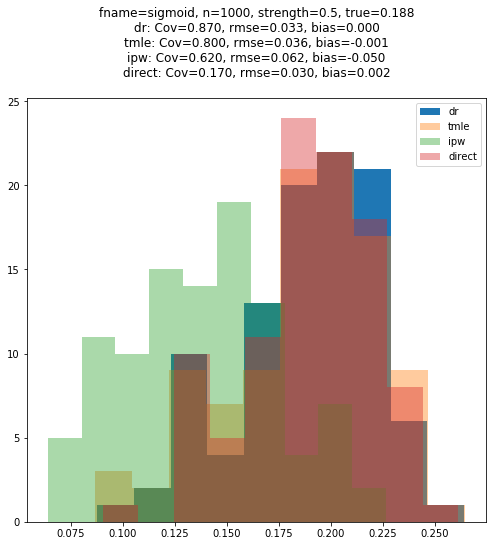

In [20]:
for fname in ['sigmoid']:
    plt.figure(figsize=(20, 20))
    it = 1
#     for n in [1000, 2000]:
    for n in [1000]:
        for iv_strength in [.5]:
            plt.subplot(3, 3, it)
            # true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}.jbl')
            # true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}_clever_{clever}.jbl')
            true, results = joblib.load(
                        f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}_clever_{clever}_l2h_{lambda_l2_h:.4f}.jbl')
            dr = np.array([r[0] for r in results])
            tmle = np.array([r[1] for r in results])
            ipw = np.array([r[2] for r in results])
            direct = np.array([r[3] for r in results])
            plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
            it += 1
    plt.tight_layout()
    plt.show()

### Results from avg models

In [ ]:
for fname in ['abs', '2dpoly', 'sigmoid', 'sin', '3dpoly', 'abspos']:
    plt.figure(figsize=(20, 20))
    it = 1
    for n in [1000, 2000]:
        for iv_strength in [.5, .7, .9]:
            plt.subplot(3, 3, it)
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}.jbl')
            dr = np.array([r[4] for r in results])
            tmle = np.array([r[5] for r in results])
            ipw = np.array([r[6] for r in results])
            direct = np.array([r[7] for r in results])
            plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
            it += 1

    plt.tight_layout()
    plt.show()